In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from skimage import io
from PIL import Image
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from stable_baselines3 import PPO

from load_ISIC2018 import load_ISIC2018_GT
from dataset_from_df import labeled_dataset_from_path, unlabeled_dataset_from_path
from model_evaluation import evaluate_model_performance
import opts
from models.nets import densenet

from easydict import EasyDict
from datetime import datetime
from pytz import timezone

# 설정 값을 EasyDict로 정의
args = EasyDict({
    "data_root": "/home/sg980429/research/All_data",
    "save_dir": "../save_files",
    'data' : 'ISIC2018',
    'num_classes': 7,
    "lbl_ratio": 0.1,
    "resize": 224,
    "batch_size": 32,
    "num_workers": 4,
    "gpu_num": 1,
    'gpu': 1,
    'arch': 'DenseNet',
    "drop_rate": 0.5,
    "lr": 1e-3,
    "num_epochs": 128,
    'RL': 'PPO',
    "episode_size": 16,
    "mini_batch_size": 4,
    "mini_num_epochs": 4,
    "controller_gpu": 2,
    "experiment_num": 123,
    # "experiment_num": datetime.now(timezone('Asia/Seoul')).strftime("%Y%m%d_%H%M%S"),

    "topk" : 50,
    })

In [2]:
args.experiment_num = 4444
args.seed = args.experiment_num

device = torch.device(f"cuda:{args.gpu_num}" if torch.cuda.is_available() else "cpu")

class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [3]:
import plotly.graph_objects as go
import numpy as np

def label_distribution(training_df):
    all_labels = training_df['GT']
    classes_num_data = np.sum(np.array(all_labels), axis=0)

    # Create the bar chart using Plotly
    fig = go.Figure(data=[
        go.Bar(x=class_names, y=classes_num_data, marker=dict(color='skyblue'), text=classes_num_data, textposition='outside')
    ])

    # Update layout for better appearance
    fig.update_layout(
        title='Training Data Class Distribution',
        xaxis_title='Class Names',
        yaxis_title='Number of Instances',
        xaxis_tickangle=-45,  # Rotate x-axis labels
        template='plotly_white',
        font=dict(size=10),
        margin=dict(l=20, r=20, t=40, b=20),
        yaxis=dict(gridcolor='rgba(0, 0, 0, 0.1)')  # Add gridlines with transparency
    )

    # Show the figure
    fig.show()

In [4]:
from sklearn.manifold import TSNE
import umap


# print(len(training_df[training_df['confidence'] > 0.99]), len(training_df[training_df['contribution'] > 0.5]))
def dim_reduction(lbl_df,ulb_df,reducer_name="TSNE"):
    lbl_features_np = np.array(lbl_df['feature_map'].tolist())
    ulb_features_np = np.array(ulb_df['feature_map'].tolist())
    combined_features = np.concatenate([lbl_features_np, ulb_features_np], axis=0)

    reducers = {"UMAP":umap.UMAP(n_components=2, random_state=42),"TSNE": TSNE(n_components=2, random_state=42)}
    reducer = reducers[reducer_name]

    features_2d = reducer.fit_transform(combined_features)
    return features_2d


/home/sg980429/anaconda3/envs/rl_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.cm as cm


def make_contour(lbl_features_2d,lbl_labels_np):
    k_knn = 3
    knn = KNeighborsClassifier(n_neighbors=k_knn)
    knn.fit(lbl_features_2d, lbl_labels_np)


    x_min, x_max = lbl_features_2d[:, 0].min() - 1, lbl_features_2d[:, 0].max() + 1
    y_min, y_max = lbl_features_2d[:, 1].min() - 1, lbl_features_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))


    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    return xx, yy, Z


In [6]:
color_maps ={
    # Diverging
    'coolwarm': plt.cm.coolwarm,
    'Spectral': plt.cm.Spectral,
    'bwr': plt.cm.bwr,
    
    # Miscellaneous
    'cubehelix': plt.cm.cubehelix,
    'terrain': plt.cm.terrain,
    'ocean': plt.cm.ocean,
    'rainbow': plt.cm.rainbow,
    'turbo':plt.cm.turbo,
} 
c = 'rainbow'
color_map = color_maps[c]

In [7]:
# exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
# methods = ['confidence', 'contribution']
# # methods = ['contribution']
# # exp_num = [123]
# num_classes = len(class_names)

# classes = range(num_classes)
# # colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))


# for x in exp_num:
#     args.experiment_num = x
#     exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')

#     map_dir = os.path.join(args.save_dir,'all_figures','feature_maps',f'figure_{args.experiment_num}')

#     os.makedirs(map_dir, exist_ok=True) 

#     df_path = os.path.join(exp_dir,"train_df.pkl")
#     training_df = pd.read_pickle(df_path)

#     # def label_distribution(training_df)



#     lbl_df = training_df[training_df['contribution'].isna()].copy()
#     ulb_df = training_df[~training_df['contribution'].isna()].copy()
    

#     features_2d = dim_reduction(lbl_df,ulb_df,reducer_name="TSNE")

#     lbl_features_2d = features_2d[:len(lbl_df)]
#     ulb_features_2d = features_2d[len(lbl_df):]
    
#     pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
#     pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)


#     lbl_labels_one_hot_np = np.array(lbl_df['labels'].to_list())
#     pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
#     GT_one_hot_np = np.array(ulb_df['GT'].tolist())


#     lbl_labels_np = np.argmax(list(lbl_labels_one_hot_np), axis=1)
#     pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)
#     GT_np = np.argmax(list(GT_one_hot_np), axis=1)

#     xx, yy, Z = make_contour(lbl_features_2d,lbl_labels_np)

#     ################################### lbl feature map visualization
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.set_style('whitegrid')
#     contour = ax.contourf(xx, yy, Z, alpha=0.4, cmap=color_map)
#     colors = color_map(np.linspace(0, 1, args.num_classes))

#     for cls, color in zip(classes, colors):
#         cls_features = lbl_features_2d[lbl_labels_np == cls]
#         ax.scatter(cls_features[:, 0], cls_features[:, 1], label=f'{class_names[cls]}', alpha=1, color=color)
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=7, frameon=False)
#     ax.axis('off')
#     ax.set_title(f'labeled data, num of data: {len(lbl_labels_np)}', fontsize=16)
#     fig.tight_layout()
#     plt.savefig(os.path.join(map_dir,f'labeled_data_featuremap_{x}.png'), dpi=300, bbox_inches='tight')
#     plt.close()
#     ####################################
#     for method in methods:
#         # for i, threshold_score in enumerate(np.linspace(0,1, 10)):
#         for i, threshold_score in enumerate(np.linspace(0,1, 21)):
            
#             score = np.array(ulb_df[method].tolist())
#             mask = score >= threshold_score

#             fig, ax = plt.subplots(figsize=(10, 6))
#             sns.set_style('whitegrid')
#             contour = ax.contourf(xx, yy, Z, alpha=0.4, cmap=color_map)
#             colors = color_map(np.linspace(0, 1, args.num_classes))

#             for cls, color in zip(classes, colors):
#                 ulb_features = ulb_features_2d[mask][pseudo_labels_np[mask] == cls]
#                 ax.scatter(ulb_features[:, 0], ulb_features[:, 1],label=f'{class_names[cls]}', alpha=1, color=color)
#             ax.axis('off')
#             ax.set_title(f'{method}_{round(threshold_score,2)},num of data: {sum(mask)}')
#             fig.tight_layout()
#             # plt.show()
#             plt.savefig(os.path.join(map_dir,f'selected_data_featuremap_{method}_{i}_{x}.png'), dpi=300, bbox_inches='tight')
#             plt.close()

#             fig, ax = plt.subplots(figsize=(10, 6))
#             sns.set_style('whitegrid')
#             contour = ax.contourf(xx, yy, Z, alpha=0.4, cmap=color_map)
#             colors = color_map(np.linspace(0, 1, args.num_classes))
#             for cls, color in zip(classes, colors):
#                 same_mask = (pseudo_labels_np[mask] == cls) & (pseudo_labels_np[mask] == GT_np[mask])
#                 ulb_features_same = ulb_features_2d[mask][same_mask]
#                 ax.scatter(
#                     ulb_features_same[:, 0], ulb_features_same[:, 1],
#                     alpha=0.8, 
#                     color=color, 
#                     marker='*', 
#                     s=50
#                 )
#             ax.axis('off')
#             ax.set_title(f'{method}_{round(threshold_score,2)}_PL==GT,num of data: {sum(pseudo_labels_np[mask] == GT_np[mask])}')
#             fig.tight_layout()
#             # plt.show()
#             plt.savefig(os.path.join(map_dir,f'correct_selected_data_{method}_{i}_{x}.png'), dpi=300, bbox_inches='tight')
#             plt.close()
                




In [8]:
def figure_generate(f, mask, threshold_score):
    # Create a meshgrid for the contour plot
    xx, yy = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
    Z = np.random.rand(100, 100)  # Replace this with your actual Z values

    # Create the figure
    fig = go.Figure()

    # Add contour plot
    fig.add_trace(go.Contour(
        z=Z,
        x=xx[0],
        y=yy[:, 0],
        colorscale='coolwarm',
        opacity=0.85,
        showscale=False
    ))

    # Add scatter plot for each class
    for cls, color in zip(classes, colors):
        ulb_features = ulb_features_2d[mask][pseudo_labels_np[mask] == cls]
        fig.add_trace(go.Scatter(
            x=ulb_features[:, 0],
            y=ulb_features[:, 1],
            mode='markers',
            name=f'{class_names[cls]}',
            marker=dict(color=color, opacity=0.75)
        ))

    # Update title based on threshold_score
    if threshold_score is None:
        title_text = f'{f}, num of data: {len(mask)}'
    else:
        title_text = f'{f}:{threshold_score}, num of data: {sum(mask)}'

    # Update layout
    fig.update_layout(
        title=title_text,
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        margin=dict(l=0, r=0, t=40, b=0)
    )

    # Show the figure
    fig.show()


In [9]:
def cm_generate(y_true, y_pred):
    # 혼동 행렬 생성
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None,labels=range(len(class_names)),zero_division=0)
    recall = recall_score(y_true, y_pred, average=None,labels=range(len(class_names)),zero_division=0)
    print(f"recall: {recall}")
    print(f"precision: {precision}")

    # 그래프 크기 설정
    fig, ax = plt.subplots(figsize=(11, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    # 제목과 축 레이블 추가
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

    # Precision 값을 오른쪽에 추가 (오른쪽 정렬)
    for i, p in enumerate(precision):
        ax.text(len(class_names) + 0.7, i + 0.5, f"{p:.2f}", ha="left", va="center", fontsize=10,
                bbox=dict(facecolor="w", edgecolor="black", boxstyle="round,pad=0.3"))

    # Recall 값을 아래에 추가 (위쪽 정렬)
    for i, r in enumerate(recall):
        ax.text(i + 0.5, len(class_names) + 0.7, f"{r:.2f}", ha="center", va="top", fontsize=10,
                bbox=dict(facecolor="w", edgecolor="black", boxstyle="round,pad=0.3"))



    # 레이블 추가
    plt.text(len(class_names) + 0.5, 0, "Per-class\nPrecision", va="top", ha="right", fontsize=10)
    plt.text(0, len(class_names) + 0.5, "Per-class Recall", va="bottom", ha="left", fontsize=10)

    plt.tight_layout()
    plt.show()

In [10]:
# # filters = ['nothing', 'confidence','uncertainty','energy','information','contribution','contributions']
# # threshold_scores = [None,0.9999, 0.05, -7,None, 0.85, 0.75]

# # filters = ['action']*10
# # threshold_scores = np.linspace(0.5, 1, 10, endpoint=False)

# for l in range(len(filters)):
#     mask, threshold_score = mask_generate(filters[l],threshold_scores[l])
#     f = filters[l]
#     plt.figure(figsize=(10, 6))



#     plt.contourf(xx, yy, Z, alpha=0.85, cmap=plt.cm.coolwarm)
#     for cls, color in zip(classes, colors):
#         ulb_features = ulb_features_2d[mask][pseudo_labels_np[mask] == cls]
#         plt.scatter(ulb_features[:, 0], ulb_features[:, 1],label=f'{class_names[cls]}', alpha=0.75, color=color)

#     if threshold_score == None:
#         plt.title(f'{f}, num of data: {len(mask)}')
#     else:
#         plt.title(f'{f}:{threshold_score},num of data: {sum(mask)}')

#     # plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
#     # plt.rc('legend', fontsize=10)
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=7, frameon=False)
#     plt.rc('legend', fontsize=11)
#     plt.tight_layout()
#     plt.axis('off')
#     # plt.savefig(f"/home/sg980429/research/now/MPS/save_files/figures/_{f}")
#     plt.show()




#     # figure_generate(filters[l],mask, threshold_score)
#     y_true = real_labels_np[mask]
#     y_pred = pseudo_labels_np[mask]

#     num_classes = np.sum(np.array(pseudo_labels_one_hot_np)[mask],axis=0)
#     plt.figure(figsize=(10, 6))
   
#     bars =  plt.bar(class_names, num_classes, color='skyblue')
#     for bar in bars:
#         yval = bar.get_height()  # 막대의 높이(y 값) 가져오기
#         plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', 
#                 ha='center', va='bottom')

#     # 축 레이블 및 제목 추가
#     plt.xlabel("Class Names")
#     plt.ylabel("Number of Instances")
#     plt.title(f"{filters[l]} / Class Distribution")
#     plt.xticks(rotation=45)  # X축 레이블을 기울여 표시
#     plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 그리드 추가

#     # 그래프 출력
#     plt.tight_layout()  # 레이아웃 자동 조정

#     plt.rc('font', size=10)        # 기본 폰트 크기
#     plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
#     plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
#     plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
#     # plt.rc('legend', fontsize=10)  # 범례 폰트 크기
#     plt.rc('figure', titlesize=20)

#     # plt.savefig(f"/home/sg980429/research/now/MPS/save_files/figures/_{f}_distribution")
#     plt.show()
#     cm_generate(y_true, y_pred)
#     print(f"{filters[l]} length: ",len(y_true))



In [30]:
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
methods = ['confidence', 'contribution']
xx = 0
method = methods[xx]
# exp_num = [123]
num_classes = len(class_names)

colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))

for method in methods:
    for x in exp_num:
        pass
args.experiment_num = x
exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')


df_path = os.path.join(exp_dir,"train_df.pkl")
training_df = pd.read_pickle(df_path)



ulb_df = training_df[~training_df['contribution'].isna()].copy()
pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)



real_labels = np.array(ulb_df['GT'].tolist())
real_labels_np = np.argmax(list(real_labels), axis=1)


real_labels_tensor = torch.tensor(real_labels_np, dtype=torch.long)
class_counts = torch.bincount(real_labels_tensor)


# 방법 1: Epsilon 추가
epsilon = 1e-6
class_weights_epsilon = 1.0 / (class_counts.float() + epsilon)


# 방법 2: 0인 클래스에 가중치 0 설정
class_weights_zero_handling = torch.where(class_counts > 0, 1.0 / class_counts.float(), torch.tensor(0.0))


# Assign weights to each sample
sample_weights = class_weights_zero_handling[real_labels_tensor]

# # Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Number of samples to draw per epoch
    replacement=True  # True for resampling, False for without replacement
)

# # Create the dataset and DataLoader
dataset = CustomDataset(sample_weights, real_labels_tensor)
dataloader = DataLoader(dataset, batch_size=16, sampler=sampler)

# Iterate through the DataLoader
for batch_idx, (inputs, targets) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    # print("Inputs:", inputs)
    # print("Targets:", targets)
    print(torch.bincount(targets))
    if batch_idx == 10:  # Break after a few batches for demonstration
        break

Batch 0:
tensor([3, 2, 3, 2, 2, 2, 2])
Batch 1:
tensor([2, 2, 1, 4, 3, 0, 4])
Batch 2:
tensor([2, 2, 1, 1, 4, 5, 1])
Batch 3:
tensor([0, 6, 1, 0, 4, 2, 3])
Batch 4:
tensor([4, 1, 3, 2, 1, 2, 3])
Batch 5:
tensor([1, 1, 2, 2, 5, 2, 3])
Batch 6:
tensor([4, 0, 3, 2, 1, 3, 3])
Batch 7:
tensor([1, 1, 6, 0, 3, 2, 3])
Batch 8:
tensor([2, 1, 5, 2, 1, 3, 2])
Batch 9:
tensor([4, 1, 2, 4, 3, 0, 2])
Batch 10:
tensor([2, 2, 0, 4, 3, 3, 2])


In [25]:
sample_weights

tensor([0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001])

In [63]:

exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
methods = ['confidence', 'contribution']
xx = 0
method = methods[xx]
# exp_num = [123]
num_classes = len(class_names)

colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))

for method in methods:
    for x in exp_num:
        args.experiment_num = x
        exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')
        

        df_path = os.path.join(exp_dir,"train_df.pkl")
        training_df = pd.read_pickle(df_path)


        
        ulb_df = training_df[~training_df['contribution'].isna()].copy()
        pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
        pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)

        

        real_labels = np.array(ulb_df['GT'].tolist())
        real_labels_np = np.argmax(list(real_labels), axis=1)

        baseline_precision = precision_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)
        baseline_recall = recall_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)

        
        threshold_scores = np.linspace(0, 1, 21)

        # 클래스별 성능을 저장할 딕셔너리
        class_performance = {class_name: {'precisions': [], 'recalls': []} for class_name in class_names}
        os.makedirs(os.path.join(args.save_dir,'figures',f'bar_{x}'), exist_ok=True) 
        
        for i, threshold in enumerate(threshold_scores):
            ulb_score = np.array(ulb_df[method].tolist())
            mask = ulb_score >= threshold
            
            y_true = real_labels[mask]
            y_pred = pseudo_labels_one_hot_np[mask]


            # Sum along rows to get counts for each class
            class_counts = y_pred.sum(axis=0)

            # Calculate the proportions
            total_samples = len(y_pred)
            class_ratios = class_counts / total_samples

            plt.figure(figsize=(10, 6))

            # Plot the bar graph
            ratio_bar = plt.bar(class_names, class_ratios, label="ratio", color=colors)

            # 막대 위에 총 갯수 표시
            for k, class_name in enumerate(class_names):
                x_pos =  k# 막대의 중심
                y_pos = class_ratios[k] # 막대 상단의 y좌표
                plt.text(x_pos, y_pos, f'{round(class_ratios[k]*100,1)}%\n{class_counts[k]}', ha='center', va='bottom', fontsize=10, color='black')
            
            
            plt.title(f"Class data ratio Bar Chart of TP, FP \nmethod: {method}, threshold: {round(threshold,2)}")
            plt.xlabel("class")
            plt.ylabel("ratio")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.ylim(0, 1)  # Proportion range is between 0 and 1
            plt.savefig(os.path.join(args.save_dir,'figures',f'bar_{x}',f'{method}_BarChart_of_ratio_{i}.png'), dpi=300, bbox_inches='tight')
            plt.close()
            # plt.show()


            metrics = {"Class": [], "TP": [], "TN": [], "FP": [], "FN": []}

            # Calculate TP, TN, FP, FN for each class
            for j in range(num_classes):
                tp = np.sum((y_true[:, j] == 1) & (y_pred[:, j] == 1))
                tn = np.sum((y_true[:, j] == 0) & (y_pred[:, j] == 0))
                fp = np.sum((y_true[:, j] == 0) & (y_pred[:, j] == 1))
                fn = np.sum((y_true[:, j] == 1) & (y_pred[:, j] == 0))
                metrics["Class"].append(f"Class {j}")
                metrics["TP"].append(tp)
                metrics["TN"].append(tn)
                metrics["FP"].append(fp)
                metrics["FN"].append(fn)

            # Convert metrics to DataFrame
            metrics_df = pd.DataFrame(metrics)

            # Melt the DataFrame for seaborn visualization
            melted_df = metrics_df.melt(id_vars="Class", var_name="Metric", value_name="Count")

            pivot_df = melted_df.pivot(index="Class", columns="Metric", values="Count").fillna(0)

            # 클래스 목록 및 각 메트릭의 데이터 추출
            tp = pivot_df["TP"]/len(y_pred)
            fp = pivot_df["FP"]/len(y_pred)



            # 누적 막대 그래프 그리기
            plt.figure(figsize=(10, 6))

            # 각 메트릭의 막대 추가 (bottom으로 누적)
            # plt.bar(class_names, tp, label="TP", color="blue")
            # plt.bar(class_names, fp, bottom=tp, label="FP", color="red")
            tp_bars = plt.bar(class_names, tp, label="TP", color="blue")
            fp_bars = plt.bar(class_names, fp, bottom=tp, label="FP", color="red")

            # 막대 위에 총 갯수 표시
            for k, class_name in enumerate(class_names):
                total_count = pivot_df["TP"][k] + pivot_df["FP"][k]  # TP + FP의 합계
                x_pos = tp_bars[k].get_x() + tp_bars[k].get_width() / 2  # 막대의 중심
                y_pos = tp[k] + fp[k]  # 막대 상단의 y좌표
                plt.text(x_pos, y_pos, f'precision: {round(tp[k]/y_pos,2)}\n{class_counts[k]}', ha='center', va='bottom', fontsize=10, color='black')


            # 그래프 설정
            
            plt.title(f"Class-wise Stacked Bar Chart of TP, FP \nmethod: {method}, threshold: {round(threshold,2)}")
            plt.xlabel("Class")
            plt.ylabel("ratio")
            plt.legend(title="Metric", loc="upper right")
            plt.xticks(rotation=45)
            plt.ylim(top=1)
            plt.tight_layout()
            plt.savefig(os.path.join(args.save_dir,'figures',f'bar_{x}',f'{method}_StackedBarChart_of_precision_{i}.png'), dpi=300, bbox_inches='tight')
            plt.close()
            # plt.show()



    


/tmp/ipykernel_153483/1563114928.py:120: RuntimeWarning: invalid value encountered in scalar divide
  plt.text(x_pos, y_pos, f'precision: {round(tp[k]/y_pos,2)}\n{class_counts[k]}', ha='center', va='bottom', fontsize=10, color='black')
/tmp/ipykernel_153483/1563114928.py:120: RuntimeWarning: invalid value encountered in scalar divide
  plt.text(x_pos, y_pos, f'precision: {round(tp[k]/y_pos,2)}\n{class_counts[k]}', ha='center', va='bottom', fontsize=10, color='black')
/tmp/ipykernel_153483/1563114928.py:120: RuntimeWarning: invalid value encountered in scalar divide
  plt.text(x_pos, y_pos, f'precision: {round(tp[k]/y_pos,2)}\n{class_counts[k]}', ha='center', va='bottom', fontsize=10, color='black')
/tmp/ipykernel_153483/1563114928.py:120: RuntimeWarning: invalid value encountered in scalar divide
  plt.text(x_pos, y_pos, f'precision: {round(tp[k]/y_pos,2)}\n{class_counts[k]}', ha='center', va='bottom', fontsize=10, color='black')
/tmp/ipykernel_153483/1563114928.py:120: RuntimeWarning:

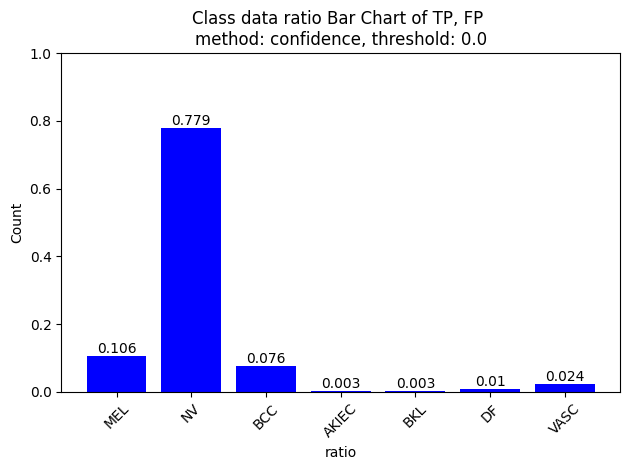

In [52]:

exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
methods = ['confidence', 'contribution']
xx = 0
method = methods[xx]
# exp_num = [123]
num_classes = len(class_names)


for method in methods:
    for x in exp_num:
        args.experiment_num = x
        exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')
        

        df_path = os.path.join(exp_dir,"train_df.pkl")
        training_df = pd.read_pickle(df_path)


        
        ulb_df = training_df[~training_df['contribution'].isna()].copy()
        pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
        pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)

        

        real_labels = np.array(ulb_df['GT'].tolist())
        real_labels_np = np.argmax(list(real_labels), axis=1)

        baseline_precision = precision_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)
        baseline_recall = recall_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)

        
        threshold_scores = np.linspace(0, 1, 21)
        os.makedirs(os.path.join(args.save_dir,'figures',f'bar_{x}'), exist_ok=True) 

        for i, threshold in enumerate(threshold_scores):
            ulb_score = np.array(ulb_df[method].tolist())
            mask = ulb_score >= threshold
            
            y_true = real_labels[mask]
            y_pred = pseudo_labels_one_hot_np[mask]


            # Sum along rows to get counts for each class
            class_counts = y_pred.sum(axis=0)

            # Calculate the proportions
            total_samples = len(y_pred)
            class_ratios = class_counts / total_samples

            # Plot the bar graph
            ratio_bar = plt.bar(class_names, class_ratios, label="ratio", color="blue")

            # 막대 위에 총 갯수 표시
            for k, class_name in enumerate(class_names):
                x_pos =  k# 막대의 중심
                y_pos = class_ratios[k] # 막대 상단의 y좌표
                plt.text(x_pos, y_pos, f'{round(class_ratios[k],3)}', ha='center', va='bottom', fontsize=10, color='black')

            plt.title(f"Class data ratio Bar Chart of TP, FP \nmethod: {method}, threshold: {round(threshold,2)}")
            plt.xlabel("class")
            plt.ylabel("ratio")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.ylim(0, 1)  # Proportion range is between 0 and 1
            plt.savefig(os.path.join(args.save_dir,'figures',f'bar_{x}',f'{method}_BarChart_of_ratio_{i}.png'), dpi=300, bbox_inches='tight')
            plt.close()
            plt.show()
            break
        break
    break




    


In [ ]:
exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
methods = ['confidence', 'contribution']
xx = 0
method = methods[xx]
# exp_num = [123]


threshold = 0.9
for method in methods:
    for x in exp_num:
        args.experiment_num = x
        exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')
        

        df_path = os.path.join(exp_dir,"train_df.pkl")
        training_df = pd.read_pickle(df_path)


        ulb_df = training_df[~training_df['contribution'].isna()].copy()
        
        ulb_score = np.array(ulb_df[method].tolist())
        mask = ulb_score >= threshold
        ulb_df = ulb_df[mask].reset_index(drop=True)

        pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
        # pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)
        break
    break

In [ ]:
class_counts = np.sum(pseudo_labels_one_hot_np, axis=0)
total_samples = len(pseudo_labels_one_hot_np)
class_ratios = class_counts/total_samples
plt.bar(range(len(class_counts)), class_ratios, tick_label=[f'Class {i}' for i in range(len(class_counts))])
plt.xlabel('Classes')
plt.ylabel('Proportion')
plt.title('Class Proportions Using Distribution')
plt.ylim(0, 1)  # Proportion range is between 0 and 1
plt.show()

In [ ]:

# exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
# methods = ['confidence', 'contribution']
# num_classes = len(class_names)


# for method in methods:
#     for x in exp_num:
#         args.experiment_num = x
#         exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')
#         os.makedirs(os.path.join(args.save_dir,'figures'), exist_ok=True) 

#         df_path = os.path.join(exp_dir,"train_df.pkl")
#         training_df = pd.read_pickle(df_path)


        
#         ulb_df = training_df[~training_df['contribution'].isna()].copy()
#         pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
#         pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)
#         y_lim = max(np.sum(pseudo_labels_one_hot_np,axis=0))

#         real_labels = np.array(ulb_df['GT'].tolist())
#         real_labels_np = np.argmax(list(real_labels), axis=1)

#         baseline_precision = precision_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)
#         baseline_recall = recall_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)

        
#         threshold_scores = np.linspace(0, 0.999, 100)

#         # 클래스별 성능을 저장할 딕셔너리
#         class_performance = {class_name: {'precisions': [], 'recalls': []} for class_name in class_names}

#         for threshold in threshold_scores:
#             ulb_score = np.array(ulb_df[method].tolist())
#             mask = ulb_score >= threshold
            
#             y_true = real_labels[mask]
#             y_pred = pseudo_labels_one_hot_np[mask]



#             precision = precision_score(y_true, y_pred, average=None, zero_division=0,  labels=range(len(class_names)))
#             recall = recall_score(y_true, y_pred, average=None, zero_division=0, labels=range(len(class_names)))
            
#             for i, class_name in enumerate(class_names):
#                 class_performance[class_name]['precisions'].append(precision[i])
#                 class_performance[class_name]['recalls'].append(recall[i])
        

#         fig, axs = plt.subplots(len(class_names), 1, figsize=(10, 6*len(class_names)), sharex=True)
#         # fig.suptitle('Class-wise Precision and Recall vs. Threshold', fontsize=16)
#         for i, (class_name, performance) in enumerate(class_performance.items()):
#             # axs[i].plot(threshold_scores, np.array(performance['precisions'])[:,i], label='Precision', color='blue')
#             # axs[i].plot(threshold_scores, np.array(performance['recalls'])[:,i], label='Recall', color='red')
#             axs[i].plot(threshold_scores, performance['precisions'], label='Precision', color='blue')
#             axs[i].plot(threshold_scores, performance['recalls'], label='Recall', color='red')
#             axs[i].axhline(baseline_precision[i], label='Precision baseline', color='blue',linestyle='--')
#             axs[i].axhline(baseline_recall[i], label='Recall_baseline', color='red',linestyle='--')
#             axs[i].set_title(f'{class_name}', fontsize=14)
#             axs[i].set_ylabel('Score', fontsize=12)
#             axs[i].legend()
#             axs[i].grid(True)
#             axs[i].set_ylim(0, 1)
#         plt.tight_layout()
#         plt.savefig(os.path.join(args.save_dir,'figures',f'precision_recall_curve_{method}_{x}.png'), dpi=300, bbox_inches='tight')
#         plt.close()

    


In [ ]:

# exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
# methods = ['confidence', 'contribution']
# num_classes = len(class_names)


# for method in methods:
#     for x in exp_num:
#         args.experiment_num = x
#         exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')
        

#         df_path = os.path.join(exp_dir,"train_df.pkl")
#         training_df = pd.read_pickle(df_path)


        
#         ulb_df = training_df[~training_df['contribution'].isna()].copy()
#         pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
#         pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)
#         y_lim = max(np.sum(pseudo_labels_one_hot_np,axis=0))

#         real_labels = np.array(ulb_df['GT'].tolist())
#         real_labels_np = np.argmax(list(real_labels), axis=1)

#         baseline_precision = precision_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)
#         baseline_recall = recall_score(real_labels_np, pseudo_labels_np, average=None, labels=range(len(class_names)), zero_division=0)

        
#         threshold_scores = np.linspace(0, 0.999, 100)

#         # 클래스별 성능을 저장할 딕셔너리
#         class_performance = {class_name: {'precisions': [], 'recalls': []} for class_name in class_names}

#         for threshold in threshold_scores:
#             ulb_score = np.array(ulb_df[method].tolist())
#             mask = ulb_score >= threshold
            
#             y_true = real_labels[mask]
#             y_pred = pseudo_labels_one_hot_np[mask]



#             precision = precision_score(y_true, y_pred, average=None, zero_division=0,  labels=range(len(class_names)))
#             recall = recall_score(y_true, y_pred, average=None, zero_division=0, labels=range(len(class_names)))
            
#             for i, class_name in enumerate(class_names):
#                 class_performance[class_name]['precisions'].append(precision[i])
#                 class_performance[class_name]['recalls'].append(recall[i])
        

#         for i, (class_name, performance) in enumerate(class_performance.items()):
#             os.makedirs(os.path.join(args.save_dir,'figures',f'{class_name}'), exist_ok=True) 
#             plt.figure(figsize=(10, 6))  # 개별 플롯 생성
#             plt.plot(threshold_scores, performance['precisions'], label='Precision', color='blue')
#             plt.plot(threshold_scores, performance['recalls'], label='Recall', color='red')
#             plt.axhline(baseline_precision[i], label='Precision baseline', color='blue', linestyle='--')
#             plt.axhline(baseline_recall[i], label='Recall baseline', color='red', linestyle='--')
#             plt.title(f'{class_name}', fontsize=14)
#             plt.xlabel('Threshold', fontsize=12)
#             plt.ylabel('Score', fontsize=12)
#             plt.legend()
#             plt.grid(True)
#             plt.ylim(0, 1)
            
#             # 파일 경로 생성 및 저장
#             save_path = os.path.join(args.save_dir,'figures',f'{class_name}', f'{class_name}_precision_recall_curve_{method}_{x}.png')
#             plt.savefig(save_path, dpi=300, bbox_inches='tight')
#             plt.close()  # 플롯 닫기

In [ ]:
performance

In [ ]:
# exp_num = [123,234,345,456,567,678,789,890,1111,2222,3333,4444]
# exp_num=[123]
# class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
# for x in exp_num:
#     args.experiment_num = x
#     exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')
#     df_path = os.path.join(exp_dir,"train_df.pkl")
#     training_df = pd.read_pickle(df_path)


   
#     ulb_df = training_df[~training_df['contribution'].isna()].copy()
#     pseudo_labels_one_hot_np = np.array(ulb_df['labels'].tolist())
#     pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)

#     real_labels = ulb_df['GT']
#     real_labels_np = np.argmax(list(real_labels), axis=1)

#     threshold_scores = np.linspace(0, 1, 11)
#     precisions = []
#     recalls = []

#     # 클래스별 성능을 저장할 딕셔너리
#     class_performance = {class_name: {'precisions': [], 'recalls': []} for class_name in class_names}

#     for threshold in threshold_scores:
#         ulb_score = np.array(ulb_df['contribution'].tolist())
#         mask = ulb_score >= threshold
        
#         y_true = real_labels_np[mask]
#         y_pred = pseudo_labels_np[mask]

#         cm = confusion_matrix(y_true, y_pred)

#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
#         plt.xlabel('Predicted label')
#         plt.ylabel('True label')
#         plt.title(f'Confusion Matrix for threshold : {round(threshold,2)}')
#         plt.show()



In [ ]:
#%% data pre-processing

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop((args.resize, args.resize), scale=(0.8, 1.0)),  # Crop with a conservative scale to retain lesions
        transforms.RandomHorizontalFlip(),  # Horizontal flip
        transforms.RandomVerticalFlip(),  # Vertical flip
        transforms.RandomRotation(degrees=15),  # Rotate by a small degree
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Slight color adjustments
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),  # Gentle Gaussian Blur
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((args.resize,args.resize)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [ ]:
exp_dir = os.path.join(args.save_dir,f'{args.data}_{args.arch}_{args.RL}_{args.experiment_num}')
exp_dir

In [ ]:
teacher_model_dir = os.path.join(exp_dir,"teacher_model")

task_predictor_dir = os.path.join(exp_dir,"task_predictor")

df_path = os.path.join(exp_dir,"train_df.pkl")

In [ ]:
training_df = pd.read_pickle(df_path)

In [ ]:
train_df, val_df, test_df = load_ISIC2018_GT(args.data_root)
num_classes = len(test_df['GT'][0])

In [ ]:
#%% data split for SSL
np.random.seed(args.seed)
train_indexes = np.random.permutation(len(train_df))
val_indexes = np.random.permutation(len(val_df))
test_indexes = np.arange(len(test_df))

num_labels = int(len(train_df)*args.lbl_ratio)
lbl_indexes = train_indexes[:num_labels]
ulb_indexes = train_indexes[num_labels:]

train_df.loc[ulb_indexes, 'labels'] = None
train_df['labels'] = train_df['labels'].astype(object)  



val_dataset = labeled_dataset_from_path(val_df, val_indexes, transforms=test_transform)
test_dataset = labeled_dataset_from_path(test_df, test_indexes, transforms=test_transform)


In [ ]:
#%% data loader

ValLoader = DataLoader(val_dataset, 
                  batch_size=args.batch_size,
                  num_workers=args.num_workers)

TestLoader = DataLoader(test_dataset, 
                  batch_size=args.batch_size,
                  num_workers=args.num_workers)


In [ ]:
backbone=densenet.densenet121
model1 = backbone(pretrained=False, drop_rate=args.drop_rate)
in_features = 1024
model1.classifier = nn.Linear(in_features, num_classes)
teacher_model = nn.SyncBatchNorm.convert_sync_batchnorm(model1)

In [ ]:
#%%
metrics = ["loss","acc", "F1", "auc"]
m = 3

task_predictor_path = os.path.join(task_predictor_dir,f"best_{metrics[m]}.pth")
check_point = torch.load(task_predictor_path)

teacher_model.load_state_dict(check_point['weights'])

test_accuracy, test_f1_score, test_auc = evaluate_model_performance(teacher_model,TestLoader,device)
print(test_accuracy, test_f1_score, test_auc)

In [ ]:
check_point.keys(), check_point['val_f1_score'],  check_point['val_auc']

In [ ]:
#%%
metrics = ["loss","acc", "F1", "auc"]
m = 3

teacher_model_path = os.path.join(teacher_model_dir,f"best_{metrics[m]}.pth")
check_point = torch.load(teacher_model_path)

teacher_model.load_state_dict(check_point['weights'])

test_accuracy, test_f1_score, test_auc = evaluate_model_performance(teacher_model,TestLoader,device)
print(test_accuracy, test_f1_score, test_auc)

In [ ]:
check_point.keys(), check_point['val_f1_score'],  check_point['val_auc']

feature map

In [ ]:
lbl_test = labeled_dataset_from_path(training_df,lbl_indexes,transforms=test_transform)

lbltest_loader = DataLoader(lbl_test, 
                  batch_size=args.batch_size,
                  num_workers=args.num_workers)

ulb_dataset = unlabeled_dataset_from_path(training_df,ulb_indexes,transforms=test_transform)
UlbLoader = DataLoader(ulb_dataset, 
                  batch_size=args.batch_size,
                  num_workers=args.num_workers)

In [ ]:
# if 'confidence' not in training_df.columns:
#     training_df['confidence'] = 0

# if 'feature_map' not in training_df.columns:
#     training_df['feature_map'] = None
# training_df['feature_map'] = training_df['feature_map'].astype(object)  

# for inputs,_, idx in tqdm(lbltest_loader):
#     inputs = inputs.to(device)
#     idx_np = idx.cpu().numpy() 
#     outputs, feature_maps = teacher_model(inputs)
#     feature_maps = feature_maps.view(feature_maps.size(0), -1).detach().cpu().numpy() 

    
#     for i, idx in enumerate(idx_np):
#         training_df.at[idx, 'feature_map'] = feature_maps[i]


In [ ]:
# for ulb_inputs, ulb_idx in tqdm(UlbLoader):
#     ulb_inputs = ulb_inputs.to(device)
#     ulb_idx_np = ulb_idx.cpu().numpy() 
#     ulb_outputs, feature_maps = teacher_model(ulb_inputs)

#     feature_maps = feature_maps.view(feature_maps.size(0), -1).detach().cpu().numpy() 
    
#     for i, idx in enumerate(ulb_idx_np):

#         training_df.at[idx, 'feature_map'] = feature_maps[i]


UPS

In [ ]:
ulb_dataset = unlabeled_dataset_from_path(train_df,ulb_indexes,transforms=test_transform)
UlbLoader = DataLoader(ulb_dataset, 
                  batch_size=args.batch_size,
                  num_workers=args.num_workers)

In [ ]:
f_pass = 5
teacher_model.train()

# for name, layer in teacher_model.named_modules():
#     layer.training = True 
ups_df = training_df.copy()
with torch.no_grad():
    for batch_idx, (inputs, indexs) in enumerate(UlbLoader):
        inputs = inputs.to(device)
        out_prob = []

        for _ in range(f_pass):
            outputs, _ = teacher_model(inputs)
            out_prob.append(F.softmax(outputs, dim=1)) #for selecting positive pseudo-labels
        out_prob = torch.stack(out_prob)

        out_std = torch.std(out_prob, dim=0)
        out_prob = torch.mean(out_prob, dim=0)
        max_value, max_idx = torch.max(out_prob, dim=1)
        max_std = out_std.gather(1, max_idx.view(-1,1))


        confidence = max_value.cpu()
        uncertainty = max_std.squeeze(1).cpu().detach().numpy()
        ups_df.loc[indexs, 'uncertainty'] = uncertainty


In [ ]:
ups_df.sample()

InPL

In [ ]:
energy_df = ups_df.copy()

In [ ]:
ulb_dataset = unlabeled_dataset_from_path(train_df,ulb_indexes,transforms=train_transform)
UlbLoader = DataLoader(ulb_dataset, 
                  batch_size=args.batch_size,
                  num_workers=args.num_workers)

In [ ]:
teacher_model.eval()

with torch.no_grad():
    for batch_idx, (inputs, indexs) in enumerate(UlbLoader):
        inputs = inputs.to(device)
        outputs, features = teacher_model(inputs)
        energy = -torch.logsumexp(outputs, dim=1).cpu().detach().numpy()
        # energy = -torch.logsumexp(features, dim=1).cpu().detach().numpy()

        # mask_raw = energy.le(-8)
        # break
        energy_df.loc[indexs, 'energy'] = energy



In [ ]:
energy_df.sample()

ACPL

In [ ]:
import faiss
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributed as dist
from easydict import EasyDict as edict
from loguru import logger
from sklearn.mixture import GaussianMixture

In [ ]:
def build_local_graph(x_embed, u_embed, args):
    # GPU
    index_ulf = faiss.IndexFlatIP(x_embed.shape[1])
    res_ulf = faiss.StandardGpuResources()
    # gpu_index_ulf = faiss.index_cpu_to_all_gpus(index_ulf)
    gpu_index_ulf = faiss.index_cpu_to_gpu(res_ulf, args.gpu, index_ulf)
    gpu_index_ulf.add(x_embed)
    # index_ulf.add(x_embed)
    D_ulf, I_ulf = gpu_index_ulf.search(u_embed, args.topk)
    # D_ulf, I_ulf = index_ulf.search(u_embed, args.topk)
    # del gpu_index_ulf
    return edict({"d": D_ulf, "i": I_ulf})

In [ ]:
def get_ds(local_info):
    ds = local_info["d"].mean(1)
    ds = (ds - ds.min()) / (ds.max() - ds.min())
    ds = ds.reshape(-1, 1)
    return ds

In [ ]:
def build_GMM(local_ds, num_gmm_sets=3, fig=False, name="Local Density"):
    target = local_ds
    gmm1 = GaussianMixture(
        n_components=num_gmm_sets,
        max_iter=20,
        tol=1e-2,
        reg_covar=5e-7,
        random_state=1,
    )

    gmm1.fit(target)
    pred = gmm1.predict(target)
    info_idx = pred[target.argmin()]
    high_idx = pred[target.argmax()]
    high_target = (pred == high_idx).nonzero()[0]
    info_target = (pred == info_idx).nonzero()[0]

    if num_gmm_sets == 3:
        uncertain_idx = 3 - info_idx - high_idx
        uncertain_target = (pred == uncertain_idx).nonzero()[0]

    if fig:
        plt.hist(
            target[high_target],
            bins=200,
            range=(0.0, 1.0),
            edgecolor="black",
            alpha=0.5,
            label=f"High {name}",
        )
        plt.hist(
            target[info_target],
            bins=200,
            range=(0.0, 1.0),
            edgecolor="black",
            alpha=0.5,
            label=f"Informative {name}",
        )
        if num_gmm_sets == 3:
            plt.hist(
                target[uncertain_target],
                bins=200,
                range=(0.0, 1.0),
                edgecolor="black",
                alpha=0.5,
                label=f"Uncertain {name}",
            )
        plt.legend()
        plt.grid()
        # plt.savefig(f"/home/sg980429/research/now/MPS/save_files/isic_densenet_PPO_0/{0}")
        plt.clf()
    if num_gmm_sets == 3:
        return high_target, uncertain_target, info_target
    else:
        return high_target, info_target

In [ ]:
def anchor_purify(local_info, sel):
    result_idxs = []
    for i in range(local_info["i"][sel].shape[0]):
        unlabel_node = local_info["i"][sel[i]]
        mask = np.asarray(
            [
                sel[i] in local_info["i"][unlabel_node[j]]
                for j in range(unlabel_node.shape[0])
            ]
        )

        mask_idxs = mask.nonzero()[0]
        result_idxs.append(mask_idxs)

    result_mask = np.asarray([i.shape[0] for i in result_idxs])
    anchor_idxs = sel[(result_mask == result_mask.min()).nonzero()[0]]
    return anchor_idxs

actions

In [ ]:
action_df = energy_df.copy()
ulb_df = action_df.loc[ulb_indexes].copy()
ulb_features_np = np.array(ulb_df['feature_map'].tolist())
pseudo_labels = ulb_df.loc[list(ulb_indexes),'labels']


agent_path = os.path.join(exp_dir,"agent.zip")
lb = np.array(list(pseudo_labels))
obs = np.concatenate([ulb_features_np,lb],axis=1)
agent = PPO.load(agent_path)
actions, _ = agent.predict(obs) 

In [ ]:
actions = actions.squeeze(-1)

In [ ]:
action_df.loc[ulb_indexes,'action'] = actions

In [ ]:
action_df.sample()

visualizing

In [ ]:
training_df = action_df.copy()
ulb_df = training_df.loc[ulb_indexes].copy()
lbl_df = training_df.loc[lbl_indexes].copy()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Data setup
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
all_labels = training_df['GT']
classes_num_data = np.sum(np.array(all_labels), axis=0)

# Create the bar chart using Plotly
fig = go.Figure(data=[
    go.Bar(x=class_names, y=classes_num_data, marker=dict(color='skyblue'), text=classes_num_data, textposition='outside')
])

# Update layout for better appearance
fig.update_layout(
    title='Training Data Class Distribution',
    xaxis_title='Class Names',
    yaxis_title='Number of Instances',
    xaxis_tickangle=-45,  # Rotate x-axis labels
    template='plotly_white',
    font=dict(size=10),
    margin=dict(l=20, r=20, t=40, b=20),
    yaxis=dict(gridcolor='rgba(0, 0, 0, 0.1)')  # Add gridlines with transparency
)

# Show the figure
fig.show()

In [ ]:
# from sklearn.manifold import TSNE
# import umap


# # print(len(training_df[training_df['confidence'] > 0.99]), len(training_df[training_df['contribution'] > 0.5]))

lbl_features_np = np.array(lbl_df['feature_map'].tolist())
ulb_features_np = np.array(ulb_df['feature_map'].tolist())
# combined_features = np.concatenate([lbl_features_np, ulb_features_np], axis=0)



# reducers = {"UMAP":umap.UMAP(n_components=2, random_state=42),"TSNE": TSNE(n_components=2, random_state=42)}

# reducer_name = "TSNE"
# reducer = reducers[reducer_name]

# features_2d = reducer.fit_transform(combined_features)


In [ ]:
# lbl_features_2d = features_2d[:len(lbl_features_np)]
# ulb_features_2d = features_2d[len(lbl_features_np):]

In [ ]:
def filter_informativeness(lbl_features_np,ulb_features_np, args):
    dd = build_local_graph(lbl_features_np,ulb_features_np,args)
    local_ds = get_ds(dd)
    idxs_pack = build_GMM(local_ds,fig=True)
    sel = idxs_pack[2]
    anchor_idxs = anchor_purify(dd,sel)
    return anchor_idxs

In [ ]:
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

labels = lbl_df.loc[list(lbl_indexes),'labels']
pseudo_labels = ulb_df.loc[list(ulb_indexes),'labels']

lbl_labels_one_hot_np = labels 
pseudo_labels_one_hot_np = pseudo_labels 

lbl_labels_np = np.argmax(list(lbl_labels_one_hot_np), axis=1)
pseudo_labels_np = np.argmax(list(pseudo_labels_one_hot_np), axis=1)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# import matplotlib.cm as cm



# classes = np.unique(lbl_labels_np)
# colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))

# k_knn = 3
# knn = KNeighborsClassifier(n_neighbors=k_knn)
# knn.fit(lbl_features_2d, lbl_labels_np)


# x_min, x_max = lbl_features_2d[:, 0].min() - 1, lbl_features_2d[:, 0].max() + 1
# y_min, y_max = lbl_features_2d[:, 1].min() - 1, lbl_features_2d[:, 1].max() + 1
# xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))


# Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)


In [ ]:
# plt.figure(figsize=(10, 6))
# plt.rc('legend', fontsize=11)
# plt.contourf(xx, yy, Z, alpha=0.85, cmap=plt.cm.coolwarm)
# # plt.colorbar(label=classes)
# for cls, color in zip(classes, colors):
#     cls_features = lbl_features_2d[lbl_labels_np == cls]
#     plt.scatter(cls_features[:, 0], cls_features[:, 1], label=f'{class_names[cls]}', alpha=0.75, color=color)
# # plt.legend()
# # plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=7, frameon=False)

# # plt.tight_layout()
# plt.axis('off')
# plt.title(f'labeled data, num of data: {len(labels)}')

# plt.show()

In [ ]:
# def figure_generate(f, mask, threshold_score):
#     # Create a meshgrid for the contour plot
#     xx, yy = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
#     Z = np.random.rand(100, 100)  # Replace this with your actual Z values

#     # Create the figure
#     fig = go.Figure()

#     # Add contour plot
#     fig.add_trace(go.Contour(
#         z=Z,
#         x=xx[0],
#         y=yy[:, 0],
#         colorscale='coolwarm',
#         opacity=0.85,
#         showscale=False
#     ))

#     # Add scatter plot for each class
#     for cls, color in zip(classes, colors):
#         ulb_features = ulb_features_2d[mask][pseudo_labels_np[mask] == cls]
#         fig.add_trace(go.Scatter(
#             x=ulb_features[:, 0],
#             y=ulb_features[:, 1],
#             mode='markers',
#             name=f'{class_names[cls]}',
#             marker=dict(color=color, opacity=0.75)
#         ))

#     # Update title based on threshold_score
#     if threshold_score is None:
#         title_text = f'{f}, num of data: {len(mask)}'
#     else:
#         title_text = f'{f}:{threshold_score}, num of data: {sum(mask)}'

#     # Update layout
#     fig.update_layout(
#         title=title_text,
#         showlegend=True,
#         xaxis=dict(visible=False),
#         yaxis=dict(visible=False),
#         margin=dict(l=0, r=0, t=40, b=0)
#     )

#     # Show the figure
#     fig.show()


In [ ]:
real_labels = ulb_df.loc[list(ulb_indexes),'GT']
real_labels_np = np.argmax(list(real_labels), axis=1)

In [ ]:
real_labels_np

In [ ]:
pseudo_labels_np

In [ ]:
def cm_generate(y_true, y_pred):
    # 혼동 행렬 생성
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None,labels=range(len(class_names)),zero_division=0)
    recall = recall_score(y_true, y_pred, average=None,labels=range(len(class_names)),zero_division=0)
    print(f"recall: {recall}")
    print(f"precision: {precision}")

    # 그래프 크기 설정
    fig, ax = plt.subplots(figsize=(11, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    # 제목과 축 레이블 추가
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

    # Precision 값을 오른쪽에 추가 (오른쪽 정렬)
    for i, p in enumerate(precision):
        ax.text(len(class_names) + 0.7, i + 0.5, f"{p:.2f}", ha="left", va="center", fontsize=10,
                bbox=dict(facecolor="w", edgecolor="black", boxstyle="round,pad=0.3"))

    # Recall 값을 아래에 추가 (위쪽 정렬)
    for i, r in enumerate(recall):
        ax.text(i + 0.5, len(class_names) + 0.7, f"{r:.2f}", ha="center", va="top", fontsize=10,
                bbox=dict(facecolor="w", edgecolor="black", boxstyle="round,pad=0.3"))



    # 레이블 추가
    plt.text(len(class_names) + 0.5, 0, "Per-class\nPrecision", va="top", ha="right", fontsize=10)
    plt.text(0, len(class_names) + 0.5, "Per-class Recall", va="bottom", ha="left", fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:

def mask_generate(filter,threshold_score=None):
    if filter == 'nothing':
        mask = np.array(range(len(ulb_df)))

    elif filter == 'confidence':

        ulb_score= np.array(ulb_df['confidence'].tolist())
        mask = ulb_score >= threshold_score

    elif filter == 'uncertainty':

        ulb_score= np.array(ulb_df['uncertainty'].tolist())
        mask = ulb_score <= threshold_score

    elif filter == 'energy':

        ulb_score= np.array(ulb_df['energy'].tolist())   
        mask = ulb_score <= threshold_score

    elif filter == 'information':
        anchor_idxs = filter_informativeness(lbl_features_np,ulb_features_np, args)
        mask = anchor_idxs

    elif filter == 'contribution':

        ulb_score= np.array(ulb_df['contribution'].tolist())
        mask = ulb_score >= threshold_score

    elif filter == 'action':

        ulb_score= np.array(ulb_df['action'].tolist())
        mask = ulb_score >= threshold_score
        

    elif filter == 'contributions':

        ulb_score= np.array(ulb_df['contributions'].apply(lambda x : np.mean(np.array(x[:-5]),axis=0)).tolist())
        mask = ulb_score >= threshold_score
    return mask, threshold_score

In [ ]:
filters = ['nothing', 'confidence','uncertainty','energy','information','contribution','contributions','action']
threshold_scores = [None,0.9, 0.05, -7,None, 0.85, 0.5, 0.9]

In [ ]:
# # filters = ['nothing', 'confidence','uncertainty','energy','information','contribution','contributions']
# # threshold_scores = [None,0.9999, 0.05, -7,None, 0.85, 0.75]

# # filters = ['action']*10
# # threshold_scores = np.linspace(0.5, 1, 10, endpoint=False)

# for l in range(len(filters)):
#     mask, threshold_score = mask_generate(filters[l],threshold_scores[l])
#     f = filters[l]
#     plt.figure(figsize=(10, 6))



#     plt.contourf(xx, yy, Z, alpha=0.85, cmap=plt.cm.coolwarm)
#     for cls, color in zip(classes, colors):
#         ulb_features = ulb_features_2d[mask][pseudo_labels_np[mask] == cls]
#         plt.scatter(ulb_features[:, 0], ulb_features[:, 1],label=f'{class_names[cls]}', alpha=0.75, color=color)

#     if threshold_score == None:
#         plt.title(f'{f}, num of data: {len(mask)}')
#     else:
#         plt.title(f'{f}:{threshold_score},num of data: {sum(mask)}')

#     # plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
#     # plt.rc('legend', fontsize=10)
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=7, frameon=False)
#     plt.rc('legend', fontsize=11)
#     plt.tight_layout()
#     plt.axis('off')
#     # plt.savefig(f"/home/sg980429/research/now/MPS/save_files/figures/_{f}")
#     plt.show()




#     # figure_generate(filters[l],mask, threshold_score)
#     y_true = real_labels_np[mask]
#     y_pred = pseudo_labels_np[mask]

#     num_classes = np.sum(np.array(pseudo_labels_one_hot_np)[mask],axis=0)
#     plt.figure(figsize=(10, 6))
   
#     bars =  plt.bar(class_names, num_classes, color='skyblue')
#     for bar in bars:
#         yval = bar.get_height()  # 막대의 높이(y 값) 가져오기
#         plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', 
#                 ha='center', va='bottom')

#     # 축 레이블 및 제목 추가
#     plt.xlabel("Class Names")
#     plt.ylabel("Number of Instances")
#     plt.title(f"{filters[l]} / Class Distribution")
#     plt.xticks(rotation=45)  # X축 레이블을 기울여 표시
#     plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 그리드 추가

#     # 그래프 출력
#     plt.tight_layout()  # 레이아웃 자동 조정

#     plt.rc('font', size=10)        # 기본 폰트 크기
#     plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
#     plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
#     plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
#     # plt.rc('legend', fontsize=10)  # 범례 폰트 크기
#     plt.rc('figure', titlesize=20)

#     # plt.savefig(f"/home/sg980429/research/now/MPS/save_files/figures/_{f}_distribution")
#     plt.show()
#     cm_generate(y_true, y_pred)
#     print(f"{filters[l]} length: ",len(y_true))



In [ ]:
precision_performance = {}
recall_performance = {}

filters = ['nothing', 'confidence','uncertainty','energy','contribution','contributions','action']
threshold_scores = [None,0.9, 0.05, -7, 0.85, 0.5, 0.9]

for l in range(len(filters)):
    mask, threshold_score = mask_generate(filters[l],threshold_scores[l])
    f = filters[l]
    if threshold_score is None:
        title_text = f'{f}, num of data: {len(mask)}'
    else:
        title_text = f'{f}:{threshold_score}, num of data: {sum(mask)}'
    
    print(title_text)

    y_true = real_labels_np[mask]
    y_pred = pseudo_labels_np[mask]

    precision = precision_score(y_true, y_pred, average=None,labels=range(len(class_names)),zero_division=0)
    recall = recall_score(y_true, y_pred, average=None,labels=range(len(class_names)),zero_division=0)

    # precision_performance[filters[l]+"/"+f"{threshold_scores[l]}"] = precision
    # recall_performance[filters[l]+"/"+f"{threshold_scores[l]}"] = recall

    precision_performance[filters[l]] = precision
    recall_performance[filters[l]] = recall



In [ ]:
precision_df = pd.DataFrame(precision_performance, index=class_names)
recall_df = pd.DataFrame(recall_performance, index=class_names)

In [ ]:
precision_df.loc['avg'] = [np.mean(precision_df[col]) for col in precision_df.columns]
recall_df.loc['avg'] = [np.mean(recall_df[col]) for col in recall_df.columns]

In [ ]:
combined_df = pd.concat({'precision': precision_df, 'recall': recall_df}, axis=1)

In [ ]:
combined_df.to_excel(os.path.join(exp_dir,'selecting_perform.xlsx'), index=True)